In [1]:
from models_and_trainers.BERT_style_modules import BERTStyleEncoder, BertTokenizer
from models_and_trainers.copy_gen_transformer import CopyGeneratorTransformer
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

import numpy as np
import time
import math
import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, BucketIterator

from utils.useful_utils import string_split_v3, string_split_v2, string_split_v1, nltk_bleu
from utils.dataset_loaders import SRC_TGT_pairs
import utils.beam_search as beam_search
import tqdm.notebook as tqdm 
%load_ext autoreload
%autoreload 2

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    torch.cuda.set_device(0) # choose GPU from nvidia-smi 
print("Using:", device)

Using: cuda


In [3]:
src_train_fp = "datasets/django_folds/django.fold1-10.train.src"
tgt_train_fp = "datasets/django_folds/django.fold1-10.train.tgt"
src_test_fp = "datasets/django_folds/django.fold1-10.test.src"
tgt_test_fp = "datasets/django_folds/django.fold1-10.test.tgt"

In [4]:
train_data = SRC_TGT_pairs(src_train_fp, tgt_train_fp).samples
test_data = SRC_TGT_pairs(src_test_fp, tgt_test_fp).samples

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inp = tokenizer.encode("raise an exception of class ValueError, with string")[1:-1]

print(tokenizer.convert_ids_to_tokens(inp))
print(tokenizer.convert_ids_to_tokens([1]))
special_tokens_dict = {'bos_token': '[unused0]','eos_token': '[unused1]'}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
print('We have added', num_added_toks, 'tokens')
print(tokenizer.build_inputs_with_special_tokens(inp))
print(tokenizer.all_special_tokens)

['raise', 'an', 'exception', 'of', 'class', 'value', '##er', '##ror', ',', 'with', 'string']
['[unused0]']
We have added 0 tokens
[101, 5333, 2019, 6453, 1997, 2465, 3643, 2121, 29165, 1010, 2007, 5164, 102]
['[SEP]', '[UNK]', '[unused0]', '[CLS]', '[MASK]', '[unused1]', '[PAD]']


In [6]:
def data2dataset(data):
    TEXT_FIELD = Field(sequential=True, use_vocab=False, unk_token=100, pad_token=0)
    examples = []
    
    for (src, tgt) in tqdm.tqdm(data):
        
        src_ids = tokenizer.encode(src)[1:-1]
        tgt_ids = tokenizer.encode(tgt)[1:-1]
        
        decoder_input = [tokenizer.bos_token_id] + tgt_ids
        ground_truth_code = tgt_ids + [tokenizer.eos_token_id]



        example = torchtext.data.Example.fromdict({"encoder_input":src_ids, 
                                                   "ground_truth_code":ground_truth_code, 
                                                   "decoder_input":decoder_input}, 
                                                fields={"encoder_input":("encoder_input",TEXT_FIELD), 
                                                        "ground_truth_code":("ground_truth_code",TEXT_FIELD),
                                                        "decoder_input":("decoder_input",TEXT_FIELD)})
        examples.append(example)
        
    dataset = torchtext.data.Dataset(examples,fields={"encoder_input":TEXT_FIELD, 
                                              "ground_truth_code":TEXT_FIELD, 
                                              "decoder_input":TEXT_FIELD})
    return dataset

train_dataset = data2dataset(train_data)
val_dataset = data2dataset(test_data)

In [7]:
batch_size = 16

train_iterator = BucketIterator(
    train_dataset,
    batch_size = batch_size,
    repeat=True,
    shuffle=True,
    sort=True,
    sort_key = lambda x: len(x.encoder_input)+len(x.decoder_input),
    device = device)

In [8]:
for i, batch in enumerate(train_iterator):
    idx = 0
#     print([SRC_TEXT.vocab.itos[id] for id in batch.src.cpu().numpy()[:,idx]])
    encoder_input = batch.encoder_input.cpu()[:,idx].tolist()
    decoder_input = batch.decoder_input.cpu()[:,idx].tolist()
    ground_truth_code = batch.ground_truth_code.cpu()[:,idx].tolist()
    
    print("encoder_input    :",tokenizer.convert_ids_to_tokens(encoder_input))
    print("decoder_input    :",tokenizer.convert_ids_to_tokens(decoder_input))
    print("ground_truth_code:",tokenizer.convert_ids_to_tokens(ground_truth_code))
    print()
    break

encoder_input    : ['try', ',', '[PAD]']
decoder_input    : ['[unused0]', 'try', ':']
ground_truth_code: ['try', ':', '[unused1]']



In [9]:
model = CopyGeneratorTransformer().to(device)

<All keys matched successfully>
Integrity test returns mean -9.449563975749697e-08 and norm 0.0017513044876977801


In [10]:
vocab_size = tokenizer.vocab_size

src = torch.randint(0, vocab_size, (3,2)).to(device)
tgt = torch.randint(0, vocab_size, (5,2)).to(device)

outputs = model(src, tgt)
outputs.shape

torch.Size([5, 2, 30522])

In [11]:
def rmid(arr, r_id):
    return [x for x in arr if x != r_id]

In [12]:
def nltk_bleu(refrence, prediction):
    """
    Implementation from ReCode
    and moses multi belu script sets BLEU to 0.0 if len(toks) < 4
    """
    ngram_weights = [0.25] * min(4, len(refrence))
    return sentence_bleu([refrence], prediction, weights=ngram_weights, 
                          smoothing_function=SmoothingFunction().method3)

In [13]:
valid_iterator = BucketIterator(val_dataset,
    batch_size = 16,
    sort=True,
    sort_key = lambda x: len(x.encoder_input)+len(x.decoder_input),
    device = device)

def batch_filter_ids(batch_list):
    SOS_token=tokenizer.bos_token_id
    EOS_token=tokenizer.eos_token_id
    PAD_token=tokenizer.pad_token_id
    return [[id for id in l if id not in [SOS_token,EOS_token,PAD_token]] for l in batch_list]

def evaluate(beam_size=1, log=False):
    model.eval() # Turn on the evaluation mode
    with torch.no_grad(), open("BERT_code_generator.out", "w", encoding="utf-8") as out_fp:
        BLEU_scores = []
        for i, batch in enumerate(valid_iterator):
            batch_size = batch.encoder_input.shape[1]
            
            encoder_inputs = batch.encoder_input
            predictions = beam_search.beam_search_decode(model,
                              batch_encoder_ids=encoder_inputs,
                              SOS_token=tokenizer.bos_token_id,
                              EOS_token=tokenizer.eos_token_id,
                              PAD_token=tokenizer.pad_token_id,
                              beam_size=beam_size,
                              max_length=30,
                              num_out=1)
            
            sources = encoder_inputs.transpose(0,1).cpu().tolist()
            sources = batch_filter_ids(sources)
            
            predictions = [t[0].view(-1).cpu().tolist() for t in predictions]
            predictions = batch_filter_ids(predictions)
            
            targets = batch.ground_truth_code.transpose(0,1).cpu().tolist()
            targets = batch_filter_ids(targets)
            
            if i % int(len(valid_iterator)/3) == 0:
                print("| EVALUATION | {:5d}/{:5d} batches |".format(i, len(valid_iterator)))
            
            for j in range(batch_size):
                BLEU = nltk_bleu(targets[j], predictions[j])
                BLEU_scores.append(BLEU)
                
                out_fp.write("SRC  :" + " ".join(tokenizer.convert_ids_to_tokens(sources[j])) + "\n")
                out_fp.write("TGT  :" + " ".join(tokenizer.convert_ids_to_tokens(targets[j])) + "\n")
                out_fp.write("PRED :" + " ".join(tokenizer.convert_ids_to_tokens(predictions[j])) + "\n")
                out_fp.write("BLEU :" + str(BLEU) + "\n")
                out_fp.write("\n")
        final_BLEU = np.average(BLEU_scores)
        
        out_fp.write("\n\n| EVALUATION | BLEU: {:5.2f} |\n".format(final_BLEU))
        print("| EVALUATION | BLEU: {:5.3f} |".format(final_BLEU))
    return (final_BLEU)

In [17]:
evaluate(beam_size=1)

| EVALUATION |     0/  118 batches |
| EVALUATION |    39/  118 batches |
| EVALUATION |    78/  118 batches |
| EVALUATION |   117/  118 batches |
| EVALUATION | BLEU: 0.018 |


0.018410647766389728

In [14]:
def train_step(batch):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    tgt_vocab_size = tokenizer.vocab_size
    encoder_input = batch.encoder_input
    decoder_input = batch.decoder_input
    targets = batch.ground_truth_code

    optimizer.zero_grad()
    output = model(encoder_input, decoder_input)

    loss = criterion(output.view(-1, tgt_vocab_size), targets.view(-1))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    elapsed = time.time() - start_time
    return loss

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
lr = 0.005 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.99)

In [ ]:
def train(steps=10000, log_interval=200, learning_interval=4000, eval_interval=1000):
    curves = []
    
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    step = 1
    pbar = tqdm.tqdm(train_iterator, total=steps)
    try:
        for batch in pbar:
            loss = train_step(batch)
            total_loss += loss.item()

            if step % log_interval == 0:
                cur_loss = total_loss / log_interval
                elapsed = time.time() - start_time
                pbar.set_description(f"Loss:{cur_loss:5.2f}, Perplx:{math.exp(cur_loss):5.2f}")
    #             print('| {:5d}/{:5d} steps | '
    #                   'lr {:02.4f} | ms/batch {:5.2f} | '
    #                   'loss {:5.2f} | ppl {:8.2f}'.format(
    #                     step, steps, scheduler.get_lr()[0],
    #                     elapsed * 1000 / log_interval,
    #                     cur_loss, math.exp(cur_loss)))
                total_loss = 0
                start_time = time.time()

            if step % eval_interval == 0:
                print("Evaluating model")
                outputs = evaluate()
                curves.append(outputs)
                model.train()

            if step % learning_interval == 0:
                scheduler.step()

            step += 1
            if step >= steps:
                print("Finished training")
                break
    except KeyboardInterrupt as e:
        print("keyboardInterrupt, exitting!")
        
    return curves
    

curves = train(steps=500000, log_interval=50, eval_interval=10000)

In [18]:
torch.save(model.state_dict(), "saved_models/Code_generator_BERT_encoderDecoder_django_44BLEU_stateDict_only.save")

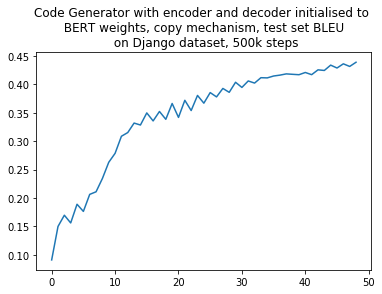

In [29]:
import matplotlib.pyplot as plt
plt.title("Code Generator with encoder and decoder initialised to \n BERT weights, copy mechanism, test set BLEU \n on Django dataset, 500k steps")
plt.plot(curves)
plt.show()